# Exploratory Data Analysis - ASL

Preliminary analysis of the ASL Alphabet dataset.

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install RAPIDS to run dimensionality reduction algorithms on the GPU.

This requires to use Google Colab with a GPU runtime.

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 28, in <module>
    if ('K80' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px

# Unzip the dataset

In [5]:
!unzip -qu '/content/drive/MyDrive/Colab Notebooks/EEAI/Project/ASL Alphabet/ASL.zip' -d 'data'

# Load the dataset

In [6]:
train_path = 'data/asl_alphabet_train/asl_alphabet_train'

In [7]:
class_labels = os.listdir(train_path)
class_mapping = {i:label for i, label in enumerate(class_labels)}

In [8]:
batch_size = 32

Here we load only 75% of the data, in order for the whole dataset to fit into memory.

In [9]:
size = 0.75
dataset = keras.utils.image_dataset_from_directory(train_path, batch_size=batch_size, class_names=class_labels, validation_split=size, subset='validation', seed=42)
dataset.element_spec

Found 87000 files belonging to 29 classes.
Using 65250 files for validation.


(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
print('Number of batches: %d' % tf.data.experimental.cardinality(dataset))

Number of batches: 2040


# Preprocessing

Enable pre-fetching to increase performance

In [11]:
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Crop to remove the blue border

In [12]:
def crop(image, label):
    ratio = (image.shape[1] - 8) / image.shape[1]
    cropped_img = tf.image.central_crop(image, ratio)
    return cropped_img, label

In [13]:
dataset = dataset.map(crop, num_parallel_calls=tf.data.AUTOTUNE)

Resize images to 96x96

In [14]:
def resize(image, label):
    resized_img = tf.image.resize(image, (96, 96))
    return resized_img, label

In [15]:
dataset = dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

Visualize the first 9 images

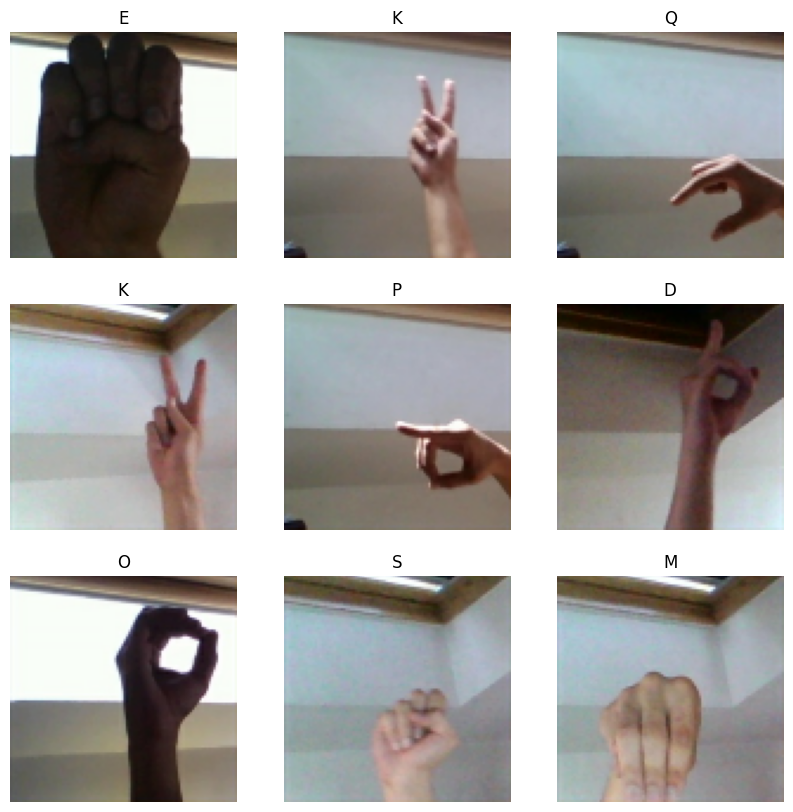

In [16]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_labels[int(label)])
    plt.axis("off")

Convert images to gray-scale

In [17]:
def gray_scale(image, label):
    gray_image = tf.image.rgb_to_grayscale(image)
    return gray_image, label

In [18]:
dataset = dataset.map(gray_scale, num_parallel_calls=tf.data.AUTOTUNE)
dataset.element_spec

(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

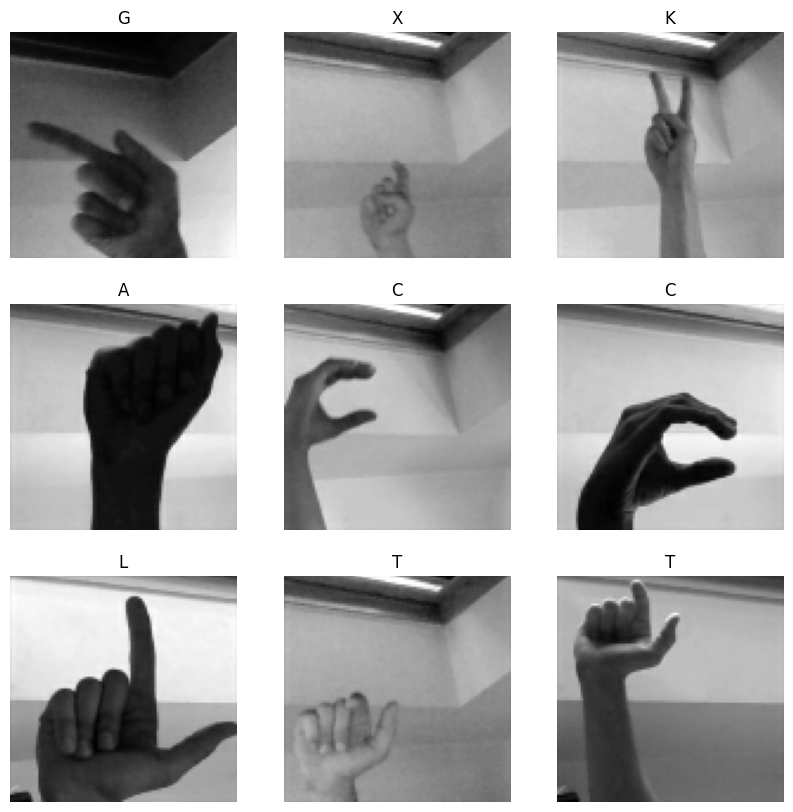

In [19]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_labels[int(label)])
    plt.set_cmap('gray')
    plt.axis("off")

# Class distribution

In [20]:
from tqdm.notebook import tqdm

In [21]:
samples = []
labels = []
for x, y in tqdm(dataset):
    samples.append(x)
    labels.append(y)

  0%|          | 0/2040 [00:00<?, ?it/s]

In [22]:
samples = np.concatenate(samples, axis=0)
labels = np.concatenate(labels, axis=0)

In [23]:
samples.shape, labels.shape

((65250, 96, 96, 1), (65250,))

In [24]:
class_labels = [class_mapping[label] for label in labels]

In [25]:
fig = px.histogram(x=class_labels)
fig.update_layout(
    title_text='Class distribution',
    xaxis_title_text='Class name',
    yaxis_title_text='Count',
    bargap=0.5,
    yaxis_range=[0, 3000]
)

# Principal Component Analysis

Flatten the array

In [26]:
X_flat = samples.reshape(len(samples), -1)
X_flat.shape

(65250, 9216)

In [27]:
from cuml.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

In [28]:
print(pca.explained_variance_ratio_)

[0.3318987 0.1755595]


In [29]:
x, y = np.transpose(X_pca)

In [30]:
fig = px.scatter(x=x, y=y, color=class_labels)
fig.show()

# t-SNE

In [31]:
from cuml.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000, perplexity=10, verbose=True)
X_tsne = tsne.fit_transform(X_flat)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning:

Starting from version 22.04, the default method of TSNE is 'fft'.



[D] [07:55:05.695456] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:69 Data size = (65250, 9216) with dim = 2 perplexity = 10.000000
[D] [07:55:05.702263] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:107 Getting distances.
[D] [07:56:34.873593] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:142 Now normalizing distances so exp(D) doesn't explode.
[D] [07:56:34.880117] /__w/cuml/cuml/cpp/src/tsne/tsne_runner.cuh:150 Searching for optimal perplexity via bisection search.
[D] [07:56:36.843153] /__w/cuml/cuml/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3192 [t-SNE] KL divergence: 0.605748176574707


In [32]:
print(tsne.kl_divergence_)

0.605748176574707


In [33]:
x, y = np.transpose(X_tsne)

In [34]:
fig = px.scatter(x=x, y=y, color=class_labels)
fig.show()

# Feature extraction with pre-trained CNN